# Bayes Classifier Training

Train and evaluate a Naive Bayes classifier using targeted feature engineering:

## Feature Set (~85 features total):

### Basic Features (29):
- **Color**: Mean & Std HSV (6 features)
- **Texture**: LBP histogram + Haralick (19 features)
- **Shape**: Aspect ratio + Hu moments (4 features)

### Material-Specific Features (6):
- **Specular (Metal)**: Bright pixel ratio, highlight sharpness, highlight contrast (3)
- **Transparency (Glass)**: Interior texture variance, edge entropy, saturation edge drop (3)

### Advanced Features (50):
- **Spatial asymmetry**: Left-right & top-bottom brightness variance (2)
- **Multi-scale LBP**: Texture at radii 1, 2, 3 (48)

These targeted features directly address metal/glass confusion patterns.

In [1]:
import sys
sys.path.append('..')

from src.config import load_config
from src.load_data import load_data
from src.models.bayes import BayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [2]:
# Load configuration
config = load_config()

print("Configuration:")
print(f"  Dataset: {config['data']['dataset_name']}")
print(f"  Classes: {', '.join(config['data']['classes'])}")
print(f"  Image size: {config['data']['image_size']}x{config['data']['image_size']}")
print(f"\nFeature extraction:")
print(f"  LBP bins: {config['bayes']['lbp_bins']}")
print(f"  LBP radius: {config['bayes']['lbp_radius']}")
print(f"  LBP points: {config['bayes']['lbp_points']}")
print(f"  Use balanced priors: {config['bayes']['use_balanced_priors']}")
print(f"  Use PCA: {config['bayes']['apply_pca']}")
print(f"\n  Feature breakdown (~85 features):")
print(f"    Color (HSV mean + std): 6")
print(f"    Texture (LBP + Haralick): 19")
print(f"    Shape (aspect + Hu): 4")
print(f"    Specular (metal detection): 3")
print(f"    Transparency (glass detection): 3")
print(f"    Spatial asymmetry: 2")
print(f"    Multi-scale LBP (r=1,2,3): 48")
print(f"    Total: ~85 features")

Configuration:
  Dataset: garythung/trashnet
  Classes: cardboard, glass, metal, paper, plastic, trash
  Image size: 224x224

Feature extraction:
  LBP bins: 16
  LBP radius: 1
  LBP points: 8
  Use balanced priors: False
  Use PCA: True

  Feature breakdown (~85 features):
    Color (HSV mean + std): 6
    Texture (LBP + Haralick): 19
    Shape (aspect + Hu): 4
    Specular (metal detection): 3
    Transparency (glass detection): 3
    Spatial asymmetry: 2
    Multi-scale LBP (r=1,2,3): 48
    Total: ~85 features


In [3]:
print("Loading datasets...")
train_dataset, val_dataset, test_dataset = load_data(split_data=True)

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_dataset)} images")
print(f"  Validation: {len(val_dataset)} images")
print(f"  Test:       {len(test_dataset)} images")

Loading datasets...

Dataset sizes:
  Training:   3537 images
  Validation: 758 images
  Test:       759 images


## Feature Extraction Visualization

Let's visualize what features we're extracting from a sample image.

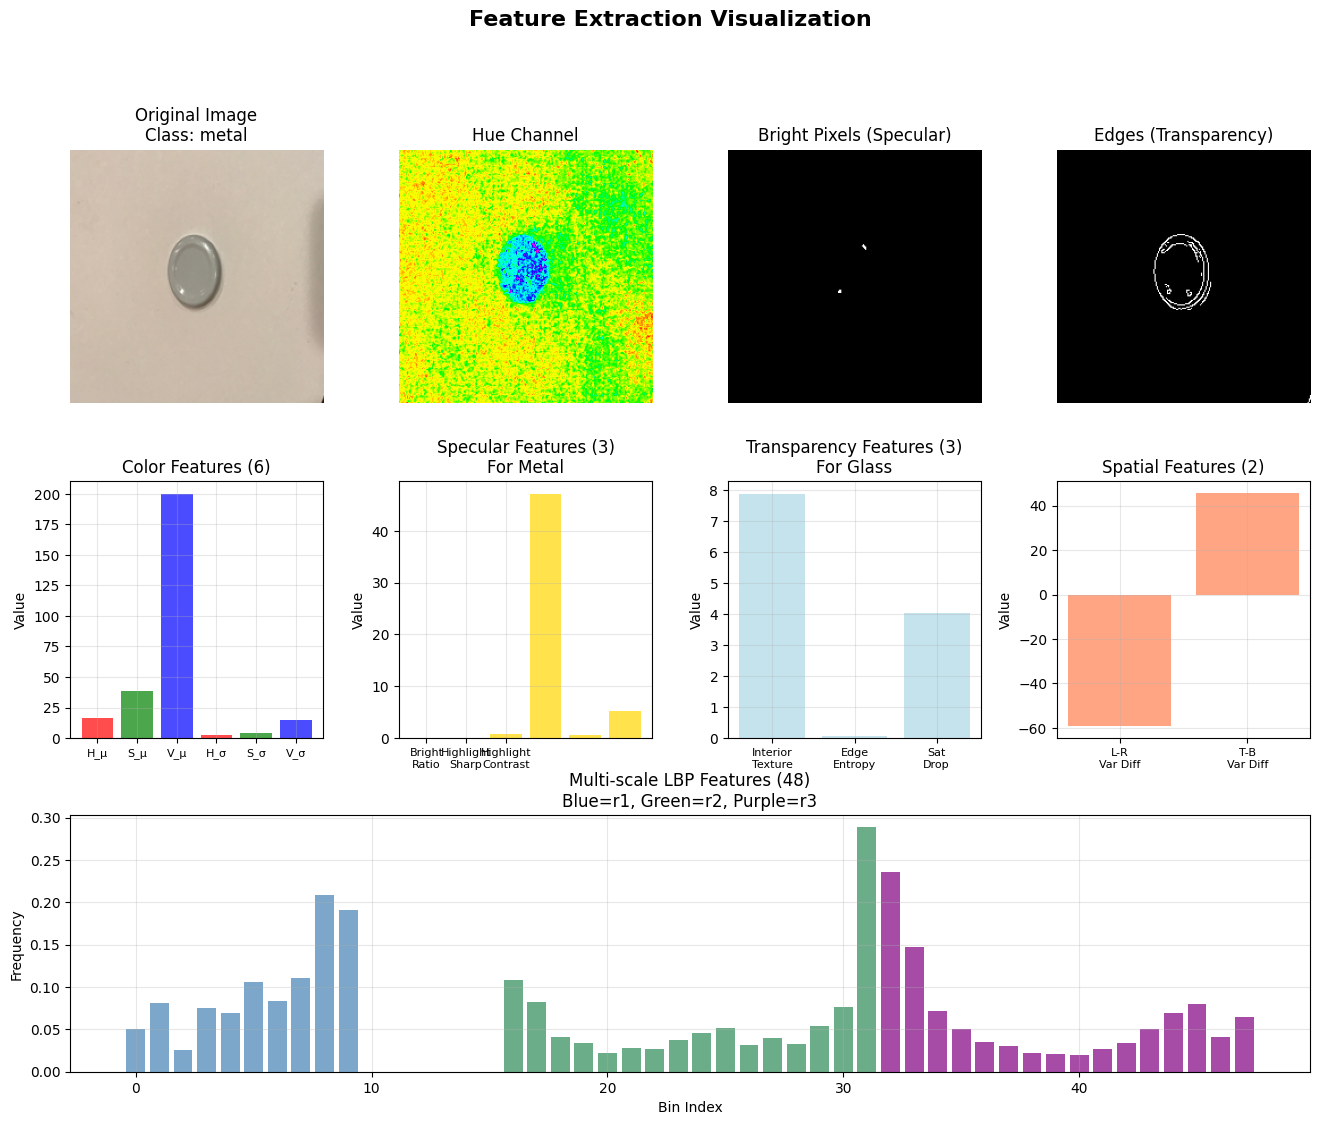


Feature Breakdown:
  Color (HSV): 6 features
  Texture (LBP + Haralick): 19 features
  Shape (aspect + Hu): 4 features
  Specular (metal): 6 features
  Transparency (glass): 3 features
  Spatial asymmetry: 2 features
  Multi-scale LBP: 48 features
  TOTAL: 56 features

Key feature values for 'metal':
  Bright pixel ratio: 0.0008 (high = metal)
  Interior texture var: 7.8917 (low = glass)
  Edge entropy: 0.0714 (high = glass)


In [4]:
from src.models.bayes import BayesFeatureExtractor
import cv2

# Create feature extractor
feature_extractor = BayesFeatureExtractor(config)

# Get a sample image
sample = train_dataset[0]
sample_image = sample['image']
sample_label = sample['label']
class_name = config['data']['classes'][sample_label]

# Resize to standard size
sample_image_resized = sample_image.resize((config['data']['image_size'], config['data']['image_size']))
sample_array = np.array(sample_image_resized)

# Extract individual feature groups
color_feat = feature_extractor.extract_color_features(sample_image_resized)
texture_feat = feature_extractor.extract_texture_features(sample_image_resized)
shape_feat = feature_extractor.extract_shape_features(sample_image_resized)
specular_feat = feature_extractor.extract_specular_features(sample_image_resized)
transparency_feat = feature_extractor.extract_transparency_features(sample_image_resized)
spatial_feat = feature_extractor.extract_spatial_asymmetry_features(sample_image_resized)
multiscale_lbp = feature_extractor.extract_multiscale_lbp(sample_image_resized)
all_features = feature_extractor.extract_features(sample_image_resized)

# Convert to HSV for visualization
hsv = cv2.cvtColor(sample_array, cv2.COLOR_RGB2HSV)

# Plot
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Row 1: Images
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(sample_image_resized)
ax1.set_title(f'Original Image\nClass: {class_name}')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(hsv[:, :, 0], cmap='hsv')
ax2.set_title('Hue Channel')
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
# Highlight visualization (bright pixels)
gray = cv2.cvtColor(sample_array, cv2.COLOR_RGB2GRAY)
_, bright_mask = cv2.threshold(gray, 217, 255, cv2.THRESH_BINARY)  # V > 0.85
ax3.imshow(bright_mask, cmap='gray')
ax3.set_title('Bright Pixels (Specular)')
ax3.axis('off')

ax4 = fig.add_subplot(gs[0, 3])
# Edge visualization
edges = cv2.Canny(gray, 50, 150)
ax4.imshow(edges, cmap='gray')
ax4.set_title('Edges (Transparency)')
ax4.axis('off')

# Row 2: Feature visualizations
ax5 = fig.add_subplot(gs[1, 0])
ax5.bar(range(6), color_feat, color=['red', 'green', 'blue', 'red', 'green', 'blue'], alpha=0.7)
ax5.set_xticks(range(6))
ax5.set_xticklabels(['H_μ', 'S_μ', 'V_μ', 'H_σ', 'S_σ', 'V_σ'], fontsize=8)
ax5.set_title('Color Features (6)')
ax5.set_ylabel('Value')
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[1, 1])
ax6.bar(range(6), specular_feat, color='gold', alpha=0.7)
ax6.set_xticks(range(3))
ax6.set_xticklabels(['Bright\nRatio', 'Highlight\nSharp', 'Highlight\nContrast'], fontsize=8)
ax6.set_title('Specular Features (3)\nFor Metal')
ax6.set_ylabel('Value')
ax6.grid(alpha=0.3)

ax7 = fig.add_subplot(gs[1, 2])
ax7.bar(range(3), transparency_feat, color='lightblue', alpha=0.7)
ax7.set_xticks(range(3))
ax7.set_xticklabels(['Interior\nTexture', 'Edge\nEntropy', 'Sat\nDrop'], fontsize=8)
ax7.set_title('Transparency Features (3)\nFor Glass')
ax7.set_ylabel('Value')
ax7.grid(alpha=0.3)

ax8 = fig.add_subplot(gs[1, 3])
ax8.bar(range(2), spatial_feat, color='coral', alpha=0.7)
ax8.set_xticks(range(2))
ax8.set_xticklabels(['L-R\nVar Diff', 'T-B\nVar Diff'], fontsize=8)
ax8.set_title('Spatial Features (2)')
ax8.set_ylabel('Value')
ax8.grid(alpha=0.3)

# Row 3: Multi-scale LBP
ax9 = fig.add_subplot(gs[2, :])
ax9.bar(range(48), multiscale_lbp, color=['steelblue']*16 + ['seagreen']*16 + ['purple']*16, alpha=0.7)
ax9.set_title('Multi-scale LBP Features (48)\nBlue=r1, Green=r2, Purple=r3')
ax9.set_xlabel('Bin Index')
ax9.set_ylabel('Frequency')
ax9.grid(alpha=0.3)

plt.suptitle('Feature Extraction Visualization', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print(f"\n{'='*60}")
print("Feature Breakdown:")
print(f"{'='*60}")
print(f"  Color (HSV): {len(color_feat)} features")
print(f"  Texture (LBP + Haralick): {len(texture_feat)} features")
print(f"  Shape (aspect + Hu): {len(shape_feat)} features")
print(f"  Specular (metal): {len(specular_feat)} features")
print(f"  Transparency (glass): {len(transparency_feat)} features")
print(f"  Spatial asymmetry: {len(spatial_feat)} features")
print(f"  Multi-scale LBP: {len(multiscale_lbp)} features")
print(f"  TOTAL: {len(all_features)} features")
print(f"{'='*60}")
print(f"\nKey feature values for '{class_name}':")
print(f"  Bright pixel ratio: {specular_feat[0]:.4f} (high = metal)")
print(f"  Interior texture var: {transparency_feat[0]:.4f} (low = glass)")
print(f"  Edge entropy: {transparency_feat[1]:.4f} (high = glass)")

## Data Augmentation Visualization

Before training, let's see how data augmentation transforms the images.

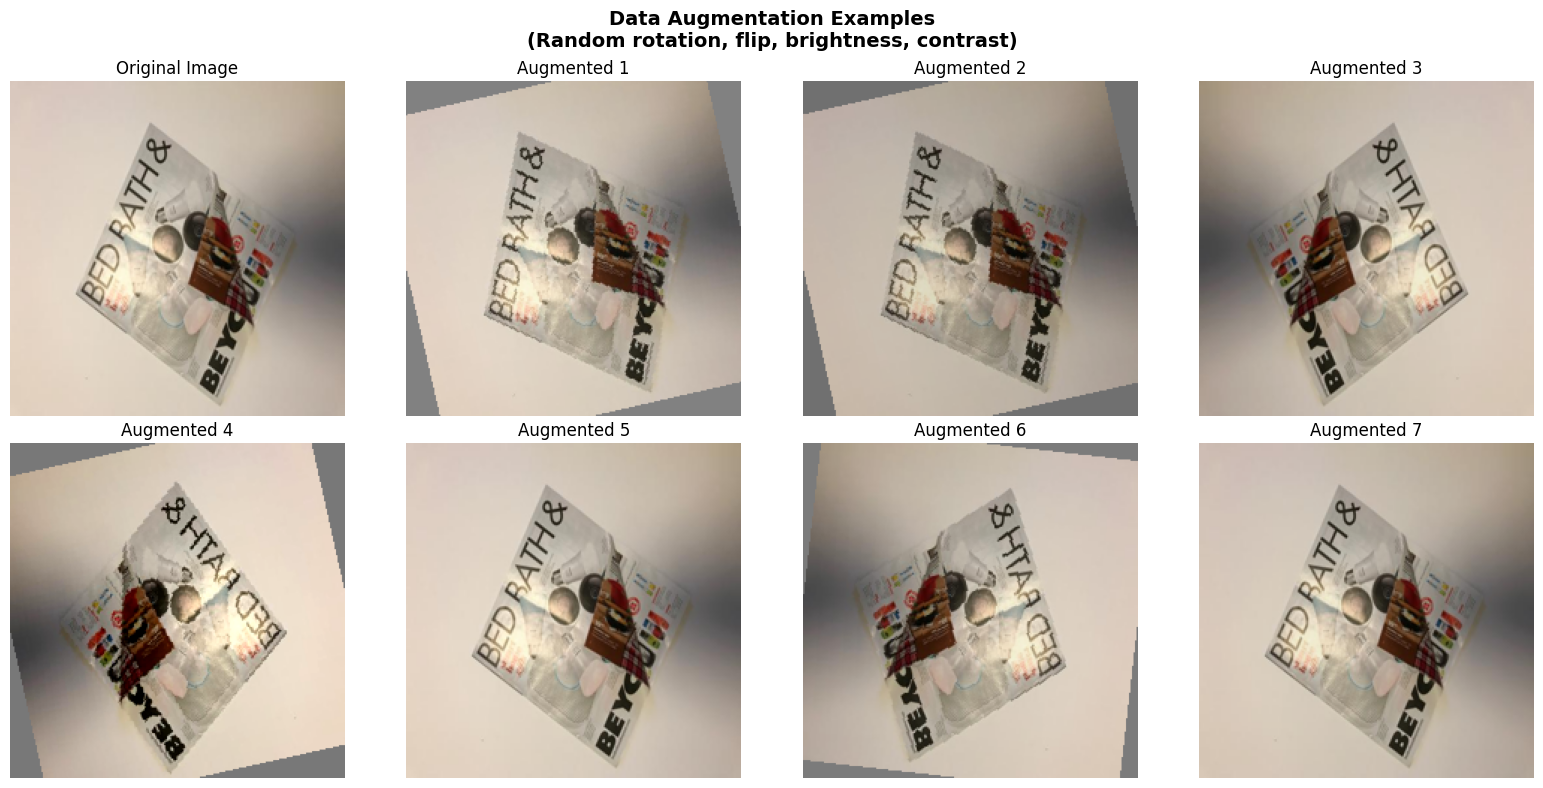

Each training image will be augmented 2 times, tripling the effective dataset size.
Original: 3537 -> With augmentation: 10611


In [5]:
# Visualize augmentation on a sample image
from src.models.bayes import BayesFeatureExtractor

feature_extractor = BayesFeatureExtractor(config)

# Get a sample
sample = train_dataset[100]
sample_image = sample['image'].resize((config['data']['image_size'], config['data']['image_size']))

# Generate augmented versions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Original
axes[0].imshow(sample_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Show 7 augmented versions
for i in range(1, 8):
    aug_image = feature_extractor.augment_image(sample_image)
    axes[i].imshow(aug_image)
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.suptitle('Data Augmentation Examples\n(Random rotation, flip, brightness, contrast)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Each training image will be augmented 2 times, tripling the effective dataset size.")
print(f"Original: {len(train_dataset)} -> With augmentation: {len(train_dataset) * 3}")

## Train Bayes Classifier

In [6]:
# Initialize classifier with balanced priors
use_balanced = config['bayes']['use_balanced_priors']
use_augmentation = config['augmentation']['enabled']
augment_factor = 2  # Create 2 augmented versions per image

print(f"Initializing Bayes Classifier...")
print(f"  Balanced priors: {use_balanced}")
print(f"  Data augmentation: {use_augmentation}")
if use_augmentation:
    print(f"  Augmentation factor: {augment_factor}")
    print(f"  This will triple the training data: {len(train_dataset)} -> {len(train_dataset) * (1 + augment_factor)}\n")

classifier = BayesClassifier(config, use_balanced_priors=use_balanced)

# Train on training dataset with augmentation
classifier.fit(train_dataset, verbose=True, use_augmentation=use_augmentation, augment_factor=augment_factor)

Initializing Bayes Classifier...
  Balanced priors: False
  Data augmentation: True
  Augmentation factor: 2
  This will triple the training data: 3537 -> 10611

Extracting features with augmentation (factor=2)...
  Original dataset size: 3537
  Effective size with augmentation: 10611


Training features: 100%|██████████| 3537/3537 [19:58<00:00,  2.95it/s]  

Feature shape: (10611, 56)
Standardizing features...
Applying PCA (reducing to 20 components)...
  Variance explained: 96.29%
Training GaussianNB classifier...
  Final feature shape: (10611, 20)
Training complete!
Training accuracy: 0.5687


## Evaluate on Validation Set

In [7]:
# Evaluate on validation set and log predictions
from pathlib import Path

log_dir = Path(config["paths"]["logs_dir"])
log_dir.mkdir(parents=True, exist_ok=True)
val_log_file = log_dir / "validation_predictions.txt"

print(f"\nEvaluating on validation set...")
print(f"Logging predictions to {val_log_file}")
val_results = classifier.evaluate(val_dataset, verbose=True, log_predictions=True, log_file=val_log_file)


Evaluating on validation set...
Logging predictions to logs\validation_predictions.txt


Extracting features for evaluation: 100%|██████████| 758/758 [02:35<00:00,  4.87it/s]

Predictions logged to: logs\validation_predictions.txt

Evaluation Results
Accuracy:  0.5923
Precision: 0.5945
Recall:    0.5923
F1 Score:  0.5862

Per-class metrics:
Class        |  Precision |     Recall |         F1 |  Support
-------------+------------+------------+------------+---------
cardboard    |     0.8621 |     0.6818 |     0.7614 |      110
glass        |     0.4733 |     0.4336 |     0.4526 |      143
metal        |     0.5402 |     0.4052 |     0.4631 |      116
paper        |     0.6827 |     0.7594 |     0.7190 |      187
plastic      |     0.5202 |     0.6988 |     0.5964 |      166
trash        |     0.3182 |     0.1944 |     0.2414 |       36


## Evaluate on Test Set

In [8]:
# Evaluate on test set and log predictions
test_log_file = log_dir / "test_predictions.txt"

print(f"\nEvaluating on test set...")
print(f"Logging predictions to {test_log_file}")
test_results = classifier.evaluate(test_dataset, verbose=True, log_predictions=True, log_file=test_log_file)

print(f"\n✓ All prediction logs saved to {log_dir}")
print(f"  - {val_log_file.name}")
print(f"  - {test_log_file.name}")


Evaluating on test set...
Logging predictions to logs\test_predictions.txt


Extracting features for evaluation: 100%|██████████| 759/759 [02:46<00:00,  4.55it/s]

Predictions logged to: logs\test_predictions.txt

Evaluation Results
Accuracy:  0.5810
Precision: 0.5904
Recall:    0.5810
F1 Score:  0.5771

Per-class metrics:
Class        |  Precision |     Recall |         F1 |  Support
-------------+------------+------------+------------+---------
cardboard    |     0.8925 |     0.7155 |     0.7943 |      116
glass        |     0.4803 |     0.3961 |     0.4342 |      154
metal        |     0.5354 |     0.4454 |     0.4862 |      119
paper        |     0.6701 |     0.7333 |     0.7003 |      180
plastic      |     0.4661 |     0.6821 |     0.5538 |      151
trash        |     0.4091 |     0.2308 |     0.2951 |       39

✓ All prediction logs saved to logs
  - validation_predictions.txt
  - test_predictions.txt


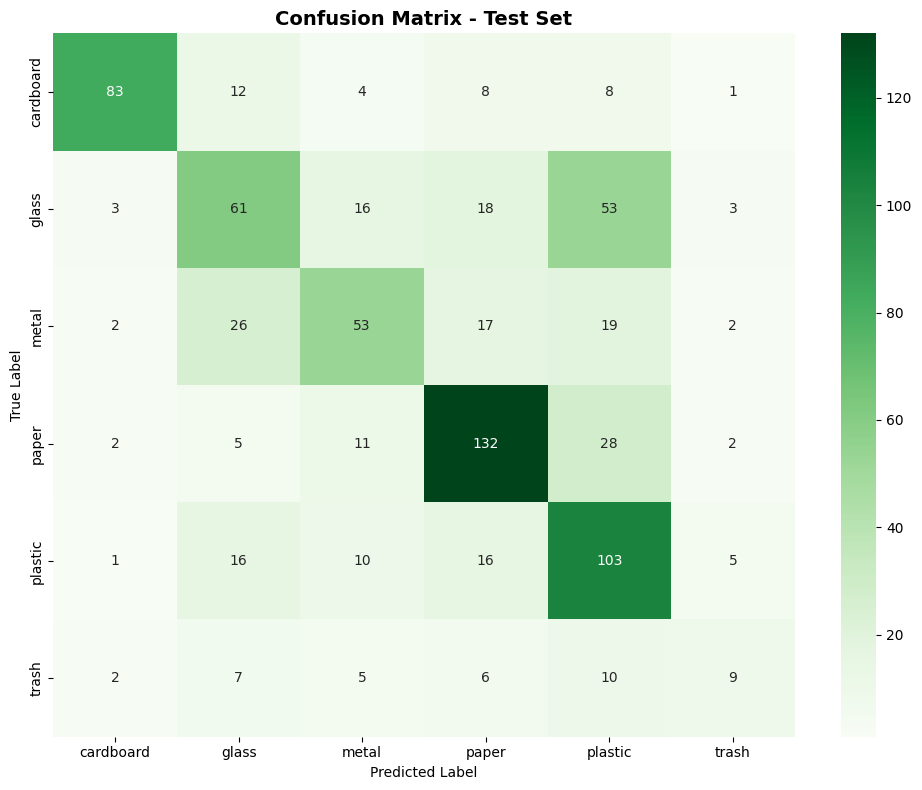


Per-class accuracy:
  cardboard   : 0.7155
  glass       : 0.3961
  metal       : 0.4454
  paper       : 0.7333
  plastic     : 0.6821
  trash       : 0.2308


In [10]:
# Plot confusion matrix for test set
cm_test = test_results['confusion_matrix']

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=config['data']['classes'],
    yticklabels=config['data']['classes']
)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nPer-class accuracy:")
for i, class_name in enumerate(config['data']['classes']):
    class_acc = cm_test[i, i] / cm_test[i].sum() if cm_test[i].sum() > 0 else 0
    print(f"  {class_name:<12}: {class_acc:.4f}")

## Compare Validation and Test Performance

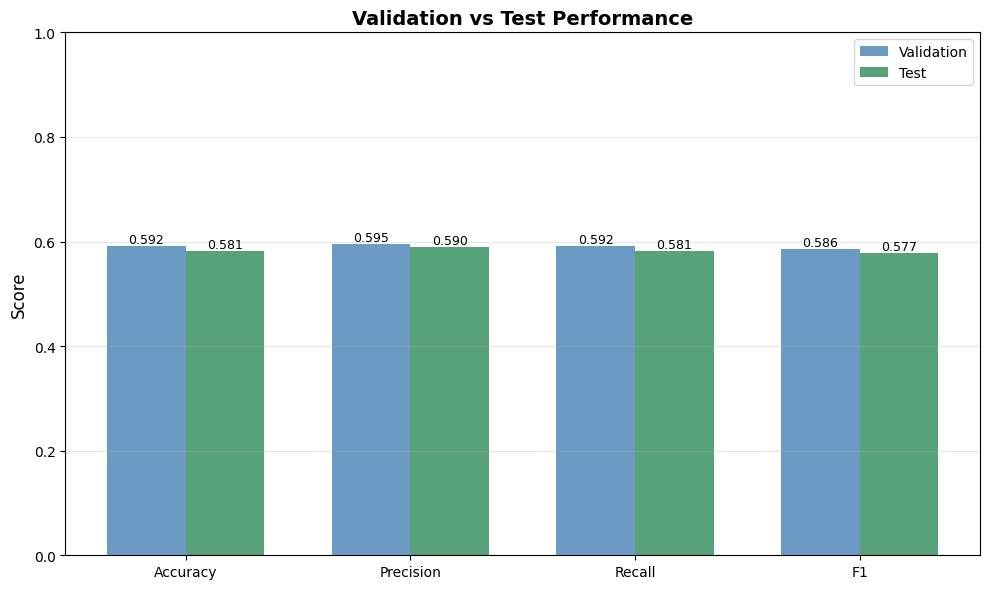


FINAL RESULTS SUMMARY

Metric       |   Validation |         Test
-------------+--------------+-------------
Accuracy     |       0.5923 |       0.5810
Precision    |       0.5945 |       0.5904
Recall       |       0.5923 |       0.5810
F1           |       0.5862 |       0.5771


In [11]:
# Compare metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics))
width = 0.35

val_scores = [val_results[m] for m in metrics]
test_scores = [test_results[m] for m in metrics]

bars1 = ax.bar(x - width/2, val_scores, width, label='Validation', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test', color='seagreen', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Validation vs Test Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}")
print(f"\n{'Metric':<12} | {'Validation':>12} | {'Test':>12}")
print(f"{'-'*12}-+-{'-'*12}-+-{'-'*12}")
for metric in metrics:
    print(f"{metric.capitalize():<12} | {val_results[metric]:>12.4f} | {test_results[metric]:>12.4f}")
print(f"{'='*60}")

## Save Model

In [ ]:
# Create models directory and save
models_dir = Path(config['paths']['models_dir'])
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / 'bayes_classifier.pkl'
classifier.save(model_path)

print(f"\nModel saved successfully!")
print(f"Path: {model_path}")

Model saved to models\bayes_classifier.pkl

Model saved successfully!
Path: models\bayes_classifier.pkl


## Feature Distribution Analysis

Analyze how features differ across waste classes to understand discriminative power.

Extracting features from sample data...
  cardboard: 100 samples
  glass: 100 samples
  metal: 100 samples
  paper: 100 samples
  plastic: 100 samples
  trash: 100 samples


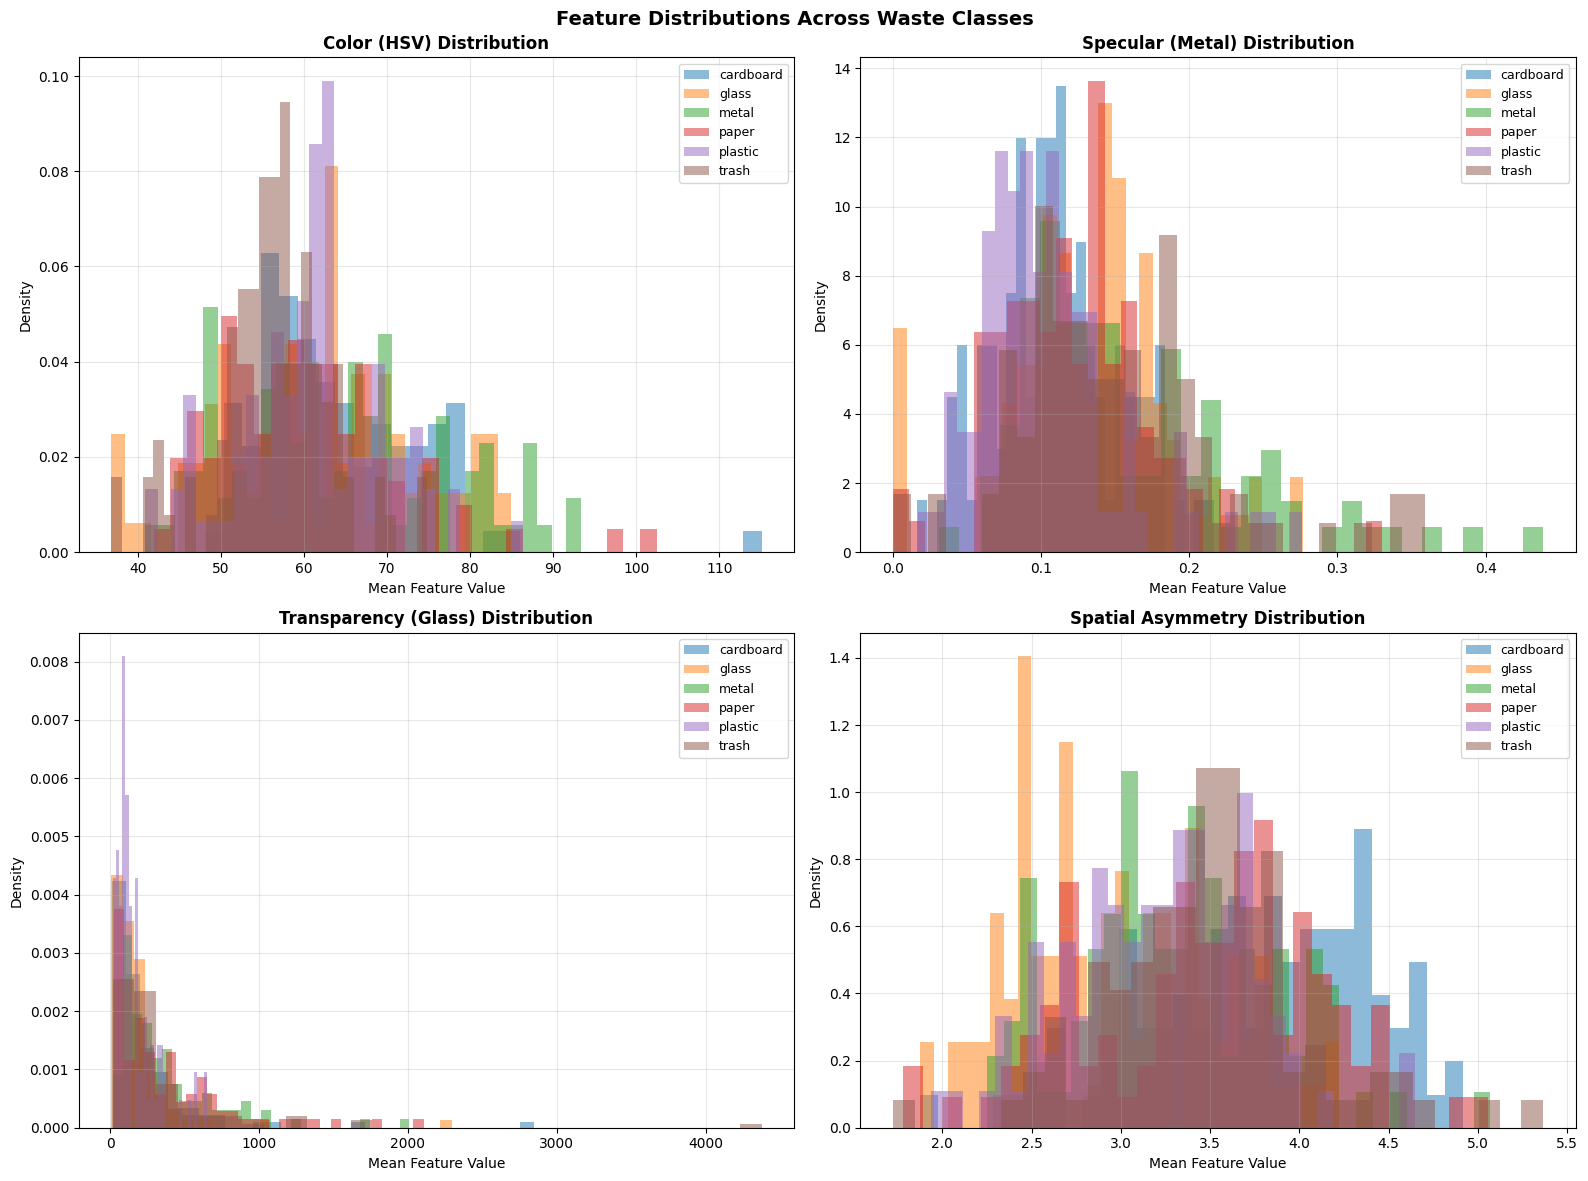

In [ ]:
# Extract features for a sample of training data to analyze distributions
from src.models.bayes import BayesFeatureExtractor

feature_extractor = BayesFeatureExtractor(config)

# Sample 100 images per class for analysis (to keep it fast)
sample_size_per_class = 100
sampled_features = []
sampled_labels = []

print("Extracting features from sample data...")
for class_idx, class_name in enumerate(config["data"]["classes"]):
    count = 0
    for item in train_dataset:
        label = item["label"]
        if label == class_idx and count < sample_size_per_class:
            image = item["image"].resize((config["data"]["image_size"], config["data"]["image_size"]))
            features = feature_extractor.extract_features(image)
            sampled_features.append(features)
            sampled_labels.append(label)
            count += 1
        if count >= sample_size_per_class:
            break
    print(f"  {class_name}: {count} samples")

sampled_features = np.array(sampled_features)
sampled_labels = np.array(sampled_labels)

# Feature indices (for single-scale LBP with 53 features)
feature_groups = {
    "Color (HSV)": list(range(6)),
    "Specular (Metal)": [29, 30, 31],
    "Transparency (Glass)": [32, 33, 34],
    "Spatial Asymmetry": [35, 36]
}

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax_idx, (group_name, feature_indices) in enumerate(feature_groups.items()):
    ax = axes[ax_idx]
    
    for class_idx, class_name in enumerate(config["data"]["classes"]):
        class_mask = sampled_labels == class_idx
        class_features = sampled_features[class_mask][:, feature_indices]
        mean_values = np.mean(class_features, axis=1)
        ax.hist(mean_values, bins=30, alpha=0.5, label=class_name, density=True)
    
    ax.set_title(f"{group_name} Distribution", fontsize=12, fontweight="bold")
    ax.set_xlabel("Mean Feature Value")
    ax.set_ylabel("Density")
    ax.legend(loc="best", fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle("Feature Distributions Across Waste Classes", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()